This databooks tries to refine the analysis done in Milestone 3 by exploring alternative approaches.

In [1]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import itertools

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

df_genres = pd.read_csv('midi_dataframe_genres_flattened.csv', parse_dates=[11], index_col='file_name')

num_games = len(df_genres.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df_genres.groupby('file_name')),
        num_games,
        (df_genres.tgdb_gametitle.notnull().sum())))

df_features = pd.read_csv('features.csv').set_index('file_name')
print("There is %d midi files with computed features"%(len(df_features)))

print("After removing not valid midi files, we have %d files"%(len(df_genres.join(df_features, how='inner').groupby('file_name'))))

There is 22179 midi files, from 3243 games, with 34510 midis matched with tgdb
There is 31483 midi files with computed features
After removing not valid midi files, we have 22005 files


In [2]:
df_genres['release_year'] = pd.to_datetime(df_genres['tgdb_releasedate']).dt.year

# Research Question

The research question is formally defined as "Is it possible to successfully categorize video game music by video game genre using music features?".

[Add assumptions]

The dataset is composed of 22005 MIDI files containing tracks from video games. The dataset was obtained by cross-referencing two databases: the Video Game Music Archive (VGMA) and TheGamesDB.net (TGDB).

The Preprocessing steps consisted in using the JSymbolic software to extract music features from the MIDIs. These features form the processed data that is considered for the classification task.

# Refinement of Methods

Milestone 3 highlighted how a standard approach to classification led to poor results. Therefore, alternative approaches have been sought. 

The succesfull approach consisted in decomposing the complex multi-classification problem into a set of binary classification problems. 
In other words, if the previous formulation of the problem is the following:

Input: all entries in the dataset 
Output: each input is classified into one of the K labels

the current one is the following:

for each possible tuple (genre1, genre2) where genre1, genre2 elements of the K classes:
    Input: entries in the dataset s.t. their label is either 'genre1' or 'genre2', but not both
    Output: each input is classified into either the 'genre1' or 'genre2' labels

It is argued that this refinement constitutes a simplification of the problem but is still completely coherent with respect to the research question. The argument is that by simplifing the problem statement it could be possible to identify music features allowing to discriminate among genres pairwise.

# Presentation of Final Results

- present results with multi-classification problem 
- present results with multiple binary classification problem 

# Discussion of Final Results

### Testing area
Big boilerplate code that can do a lot.

Choices:
- Can define the classifier
- Can choose which features to keep (as a list of features)
- Can choose which features to filter (as a mask, e.g. all features where tempo > 240)
- Can choose which genres to filter (as a mask, e.g. all games not by nintendo)
- The threshold of number of midi per genre
- To drop or not the duplicated among the remaining midis
- To print the datafram of repartition
- To print the confusion matrix

Returns:
- Stats about the number of midis and the genres considered, the number of duplicates and the repartition by genre
- The scores (accuracy for multiclass, f1 and AUCROC for the binary) on a 5-fold cross validation
- The confusion matrix on a 5-fold cross validation

In [17]:
def test_with_filters(
    clf=None,
    features_selection = df_features.columns,
    genres_filter = [True] * len(df_genres),
    feature_filter = [True] * len(df_features),
    midis_treshold=2500,
    drop_duplicates=False,
    repartition=True,
    conf_matrix=True,):
    
    
    df_pred = df_genres[genres_filter][['genre']].join(df_features[features_selection][feature_filter], how='inner').reset_index()
    df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
    df_pred.head()

    df_counts = df_pred.groupby('genre').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
    df_pred_sel = df_pred[df_pred.genre.isin(df_counts[df_counts.counts > midis_treshold]['genre'])]
    if drop_duplicates:
        df_pred_sel = df_pred_sel[~df_pred_sel['file_name'].duplicated(keep=False)]
    print("%d genres entailing %d MIDIs will be considered."%(len(np.unique(df_pred_sel['genre'])), len(df_pred_sel)))
    print('The genres are: %s'%", ".join(np.unique(df_pred_sel['genre'])))

    print("%.3f%% of the midis are duplicates"%((len(df_pred_sel)-df_pred_sel['file_name'].nunique())/len(df_pred_sel)*100))
    
    scaler = StandardScaler()
    X = scaler.fit_transform(df_pred_sel.iloc[:, 2:])
    columns = df_pred_sel.iloc[:, 2:].columns
    print(type(columns))
    y, labels = pd.factorize(df_pred_sel['genre'])
    scoring = ['accuracy']
    binary = len(labels) == 2
    if binary:
        scoring.extend(['f1', 'roc_auc'])
    scores = cross_validate(clf, X, y, cv=5, return_train_score=True, scoring=scoring)
    
    if repartition:
        val, counts_dataset = np.unique(y, return_counts=True)
        display(pd.DataFrame([counts_dataset/counts_dataset.sum()], columns=[labels[i] for i in val], index=['Repartition']))
    
#     print("===== Results =====")
    index = [['accuracy', 'accuracy'],['mean', 'std']]
    
    results = []
    results.append([])
    results.append([])
    results[0].append("%.2f%%"%(scores['train_accuracy'].mean()*100))
    results[1].append("%.2f%%"%(scores['train_accuracy'].std()*100))
    results[0].append("%.2f%%"%(scores['test_accuracy'].mean()*100))
    results[1].append("%.2f%%"%(scores['test_accuracy'].std()*100))
    if binary:
        index[0].extend(['f1-score', 'f1-score'])
        index[1].extend(['mean', 'std'])
        results.append([])
        results.append([])
        results[2].append("%.2f%%"%(scores['train_f1'].mean()*100))
        results[3].append("%.2f%%"%(scores['train_f1'].std()*100))
        results[2].append("%.2f%%"%(scores['test_f1'].mean()*100))
        results[3].append("%.2f%%"%(scores['test_f1'].std()*100))
        
        index[0].extend(['ROC AUC', 'ROC AUC'])
        index[1].extend(['mean', 'std'])
        
        results.append([])
        results.append([])
        results[4].append("%.2f%%"%(scores['train_roc_auc'].mean()*100))
        results[5].append("%.2f%%"%(scores['train_roc_auc'].std()*100))
        results[4].append("%.2f%%"%(scores['test_roc_auc'].mean()*100))
        results[5].append("%.2f%%"%(scores['test_roc_auc'].std()*100))
    display(pd.DataFrame(results, columns=['Train', 'Test'], index=index))
    if conf_matrix:
        clf.fit(X,y)
        pred = cross_val_predict(clf, X, y, cv=5)
        arr = confusion_matrix(pred, y)
        arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
        df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
        plt.figure(figsize = (10,7))

        features = np.argpartition(clf.feature_importances_, -15)[-15:]
        features = features[np.argsort(clf.feature_importances_[features])]
        sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel("Predicted class")
        plt.ylabel("Actual class")
        plt.title("Confusion matrix for logistic regression")
        plt.show();
    return (columns[features],clf.feature_importances_[features])

### Pairwise classification
Parwise for all genres which represents at least 3% of the midis.

Without the duplicates, meaning that we drop games that are combination of the pair, i.e. if we test with the pair "Action" and "Platform", we drop all games that are both.

2 genres entailing 8232 MIDIs will be considered.
The genres are: Action, Platform
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Action
Repartition,0.290452,0.709548


Train    Test
accuracy mean   99.99%  73.08%
         std     0.01%   0.15%
f1-score mean   99.99%  83.87%
         std     0.01%   0.09%
ROC AUC  mean  100.00%  71.86%
         std     0.00%   1.37%

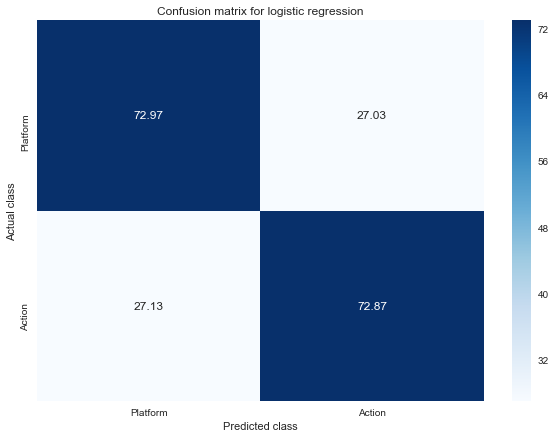

2 genres entailing 8864 MIDIs will be considered.
The genres are: Action, Shooter
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Action,Shooter
Repartition,0.849842,0.150158


Train    Test
accuracy mean   99.98%  85.54%
         std     0.01%   0.22%
f1-score mean   99.94%   7.62%
         std     0.05%   2.25%
ROC AUC  mean  100.00%  76.02%
         std     0.00%   1.69%

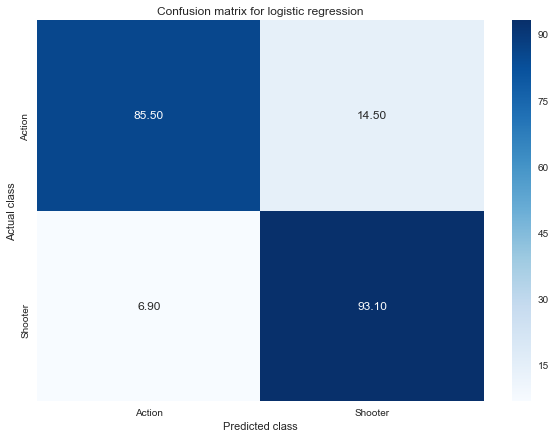

2 genres entailing 11495 MIDIs will be considered.
The genres are: Action, Role-Playing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Action,Role-Playing
Repartition,0.582427,0.417573


Train    Test
accuracy mean  100.00%  73.62%
         std     0.00%   1.05%
f1-score mean  100.00%  63.65%
         std     0.00%   1.81%
ROC AUC  mean  100.00%  80.56%
         std     0.00%   0.91%

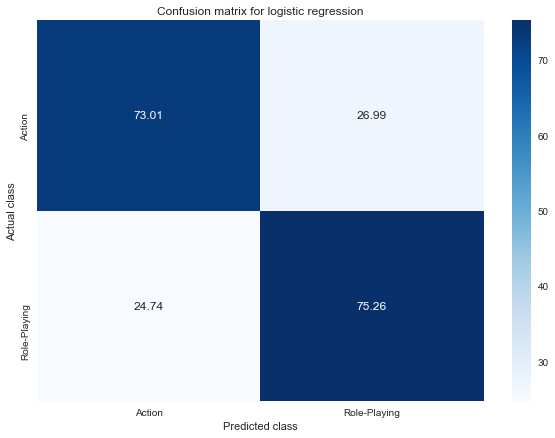

2 genres entailing 9491 MIDIs will be considered.
The genres are: Action, Fighting
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Action,Fighting
Repartition,0.847434,0.152566


Train    Test
accuracy mean   99.98%  86.01%
         std     0.01%   0.18%
f1-score mean   99.95%  18.11%
         std     0.02%   1.76%
ROC AUC  mean  100.00%  79.09%
         std     0.00%   0.96%

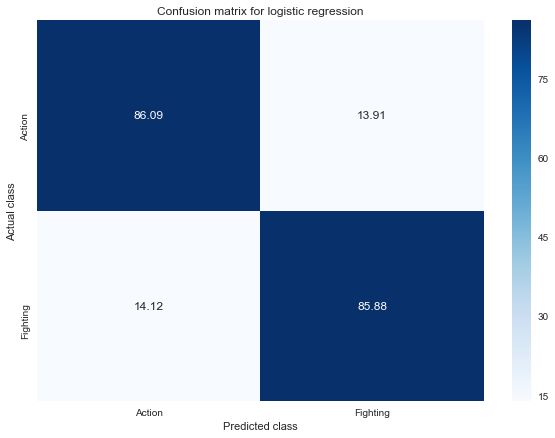

2 genres entailing 7628 MIDIs will be considered.
The genres are: Action, Adventure
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Adventure,Action
Repartition,0.260881,0.739119


Train    Test
accuracy mean   99.99%  75.83%
         std     0.01%   0.26%
f1-score mean   99.99%  85.78%
         std     0.01%   0.20%
ROC AUC  mean  100.00%  73.14%
         std     0.00%   1.21%

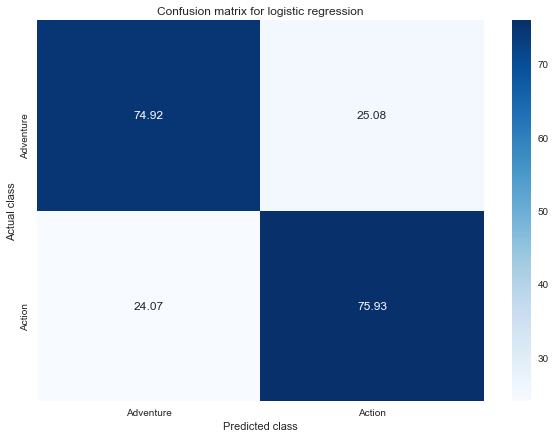

2 genres entailing 8638 MIDIs will be considered.
The genres are: Action, Puzzle
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Action,Puzzle
Repartition,0.902871,0.097129


Train    Test
accuracy mean   99.99%  90.59%
         std     0.01%   0.16%
f1-score mean   99.97%   5.96%
         std     0.04%   3.21%
ROC AUC  mean  100.00%  74.40%
         std     0.00%   1.99%

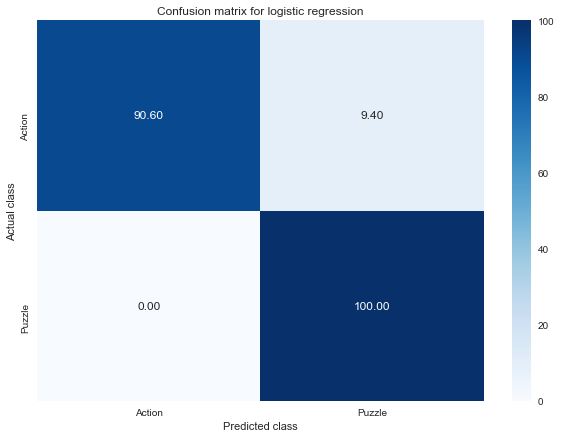

2 genres entailing 9056 MIDIs will be considered.
The genres are: Action, Racing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Action,Racing
Repartition,0.921157,0.078843


Train    Test
accuracy mean   99.99%  92.41%
         std     0.01%   0.11%
f1-score mean   99.95%   9.00%
         std     0.04%   1.47%
ROC AUC  mean  100.00%  80.37%
         std     0.00%   2.44%

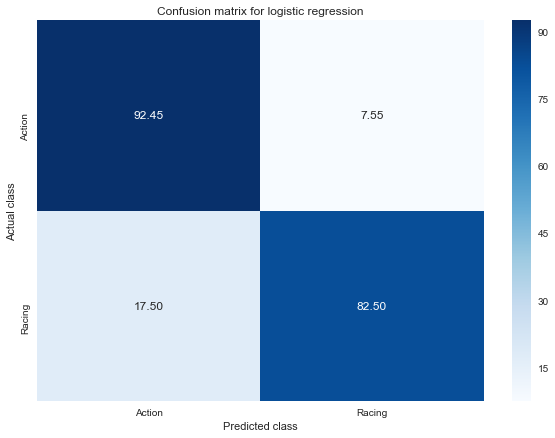

2 genres entailing 9096 MIDIs will be considered.
The genres are: Action, Sports
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Action,Sports
Repartition,0.902375,0.097625


Train    Test
accuracy mean  100.00%  90.42%
         std     0.00%   0.09%
f1-score mean  100.00%   3.74%
         std     0.00%   1.76%
ROC AUC  mean  100.00%  75.05%
         std     0.00%   0.84%

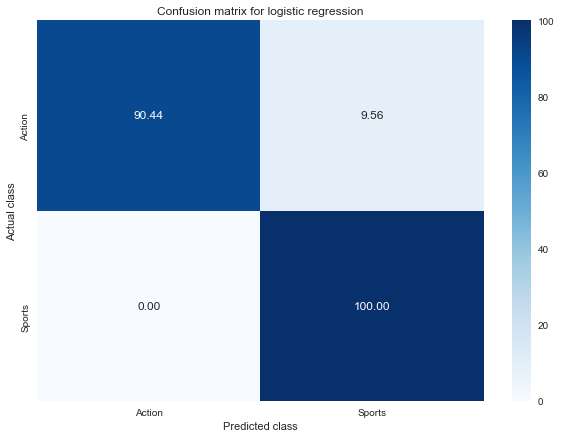

2 genres entailing 9066 MIDIs will be considered.
The genres are: Action, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Strategy,Action
Repartition,0.09486,0.90514


Train    Test
accuracy mean   99.99%  90.76%
         std     0.01%   0.13%
f1-score mean   99.99%  95.14%
         std     0.00%   0.07%
ROC AUC  mean  100.00%  76.41%
         std     0.00%   1.69%

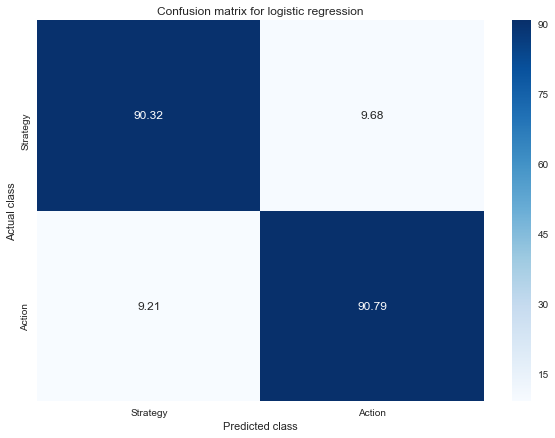

2 genres entailing 6356 MIDIs will be considered.
The genres are: Platform, Shooter
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Shooter
Repartition,0.716488,0.283512


Train    Test
accuracy mean  100.00%  74.67%
         std     0.00%   0.43%
f1-score mean  100.00%  24.85%
         std     0.00%   2.60%
ROC AUC  mean  100.00%  77.24%
         std     0.00%   0.74%

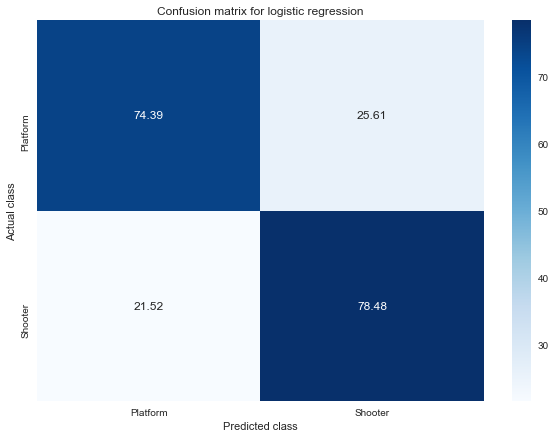

2 genres entailing 10599 MIDIs will be considered.
The genres are: Platform, Role-Playing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Role-Playing
Repartition,0.426644,0.573356


Train    Test
accuracy mean  100.00%  72.92%
         std     0.00%   0.67%
f1-score mean  100.00%  77.57%
         std     0.00%   0.77%
ROC AUC  mean  100.00%  80.21%
         std     0.00%   1.04%

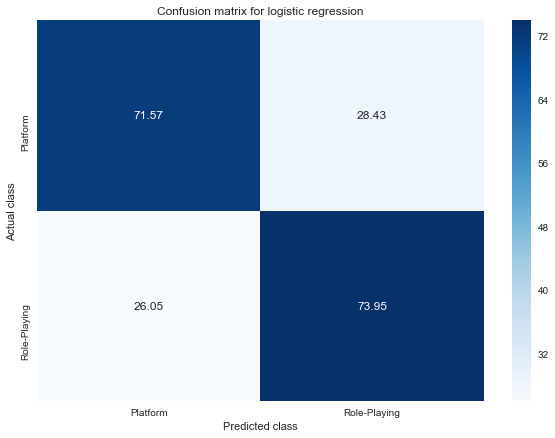

2 genres entailing 6555 MIDIs will be considered.
The genres are: Fighting, Platform
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Fighting
Repartition,0.739893,0.260107


Train    Test
accuracy mean  100.00%  78.99%
         std     0.00%   0.59%
f1-score mean  100.00%  37.83%
         std     0.00%   1.82%
ROC AUC  mean  100.00%  81.05%
         std     0.00%   0.90%

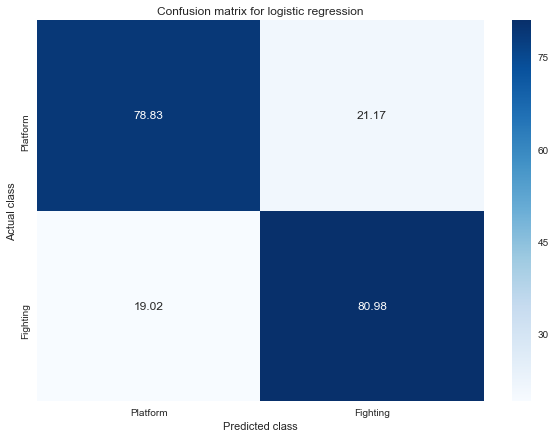

2 genres entailing 6698 MIDIs will be considered.
The genres are: Adventure, Platform
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Adventure
Repartition,0.514781,0.485219


Train    Test
accuracy mean  100.00%  67.89%
         std     0.00%   1.43%
f1-score mean  100.00%  64.36%
         std     0.00%   1.32%
ROC AUC  mean  100.00%  74.94%
         std     0.00%   1.38%

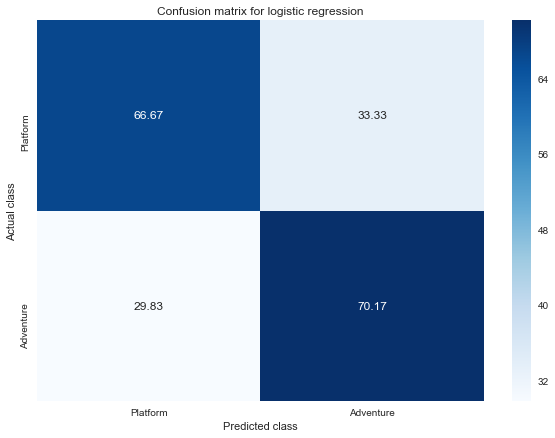

2 genres entailing 5390 MIDIs will be considered.
The genres are: Platform, Puzzle
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Puzzle
Repartition,0.825603,0.174397


Train    Test
accuracy mean  100.00%  83.34%
         std     0.00%   0.40%
f1-score mean  100.00%   9.04%
         std     0.00%   3.73%
ROC AUC  mean  100.00%  73.66%
         std     0.00%   1.17%

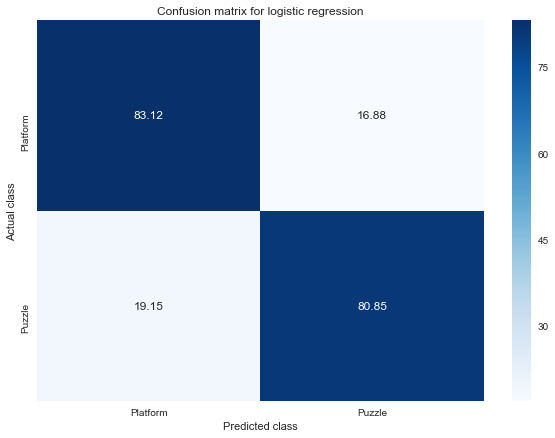

2 genres entailing 5762 MIDIs will be considered.
The genres are: Platform, Racing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Racing
Repartition,0.862548,0.137452


Train    Test
accuracy mean  100.00%  86.95%
         std     0.00%   0.12%
f1-score mean  100.00%  13.55%
         std     0.00%   1.53%
ROC AUC  mean  100.00%  80.11%
         std     0.00%   1.72%

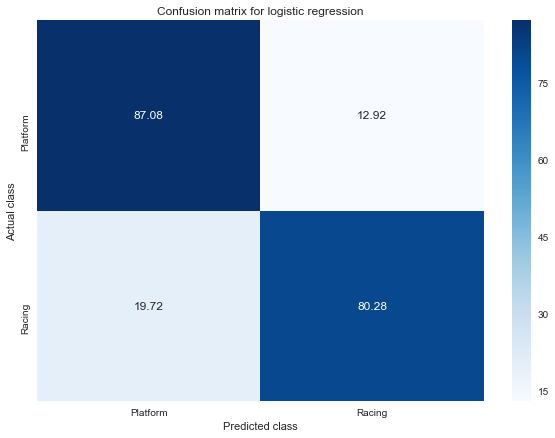

2 genres entailing 5884 MIDIs will be considered.
The genres are: Platform, Sports
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Sports
Repartition,0.828858,0.171142


Train    Test
accuracy mean  100.00%  83.51%
         std     0.00%   0.18%
f1-score mean  100.00%   7.26%
         std     0.00%   1.40%
ROC AUC  mean  100.00%  74.30%
         std     0.00%   1.55%

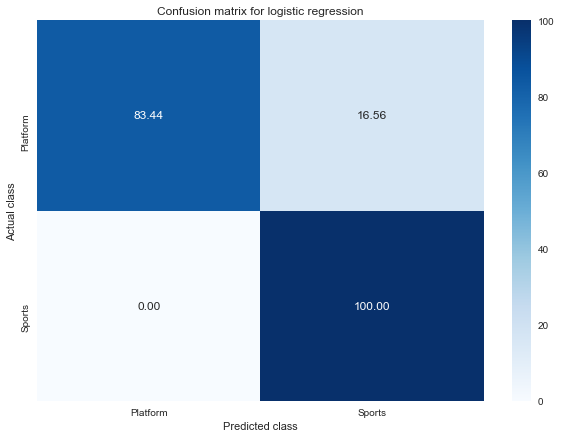

2 genres entailing 6086 MIDIs will be considered.
The genres are: Platform, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Platform,Strategy
Repartition,0.820079,0.179921


Train    Test
accuracy mean  100.00%  83.14%
         std     0.00%   0.31%
f1-score mean  100.00%  13.90%
         std     0.00%   2.43%
ROC AUC  mean  100.00%  76.60%
         std     0.00%   1.49%

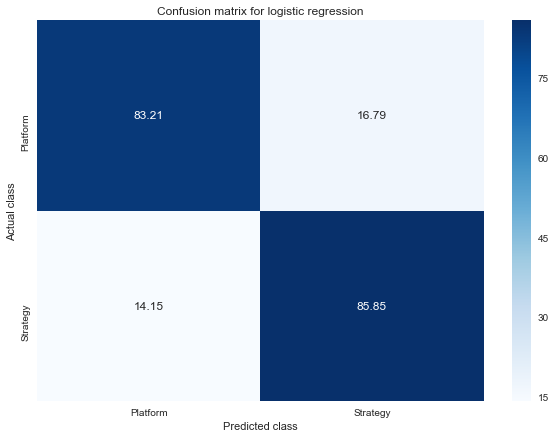

2 genres entailing 8637 MIDIs will be considered.
The genres are: Role-Playing, Shooter
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Role-Playing,Shooter
Repartition,0.749334,0.250666


Train    Test
accuracy mean  100.00%  79.31%
         std     0.01%   0.89%
f1-score mean   99.99%  36.85%
         std     0.01%   2.09%
ROC AUC  mean  100.00%  83.00%
         std     0.00%   0.34%

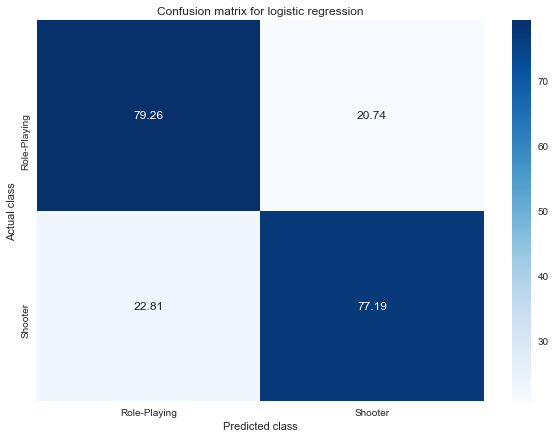

2 genres entailing 4075 MIDIs will be considered.
The genres are: Fighting, Shooter
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Shooter,Fighting
Repartition,0.548221,0.451779


Train    Test
accuracy mean   99.98%  70.38%
         std     0.02%   0.51%
f1-score mean   99.98%  62.31%
         std     0.02%   0.98%
ROC AUC  mean  100.00%  78.62%
         std     0.00%   0.61%

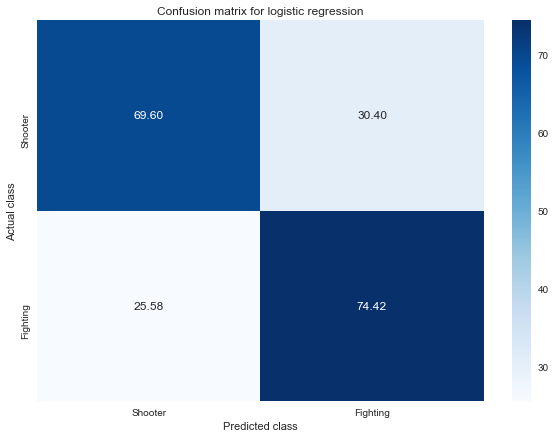

2 genres entailing 6336 MIDIs will be considered.
The genres are: Adventure, Shooter
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Adventure,Shooter
Repartition,0.701547,0.298453


Train    Test
accuracy mean   99.98%  76.09%
         std     0.01%   0.57%
f1-score mean   99.96%  41.60%
         std     0.02%   1.82%
ROC AUC  mean  100.00%  80.34%
         std     0.00%   0.85%

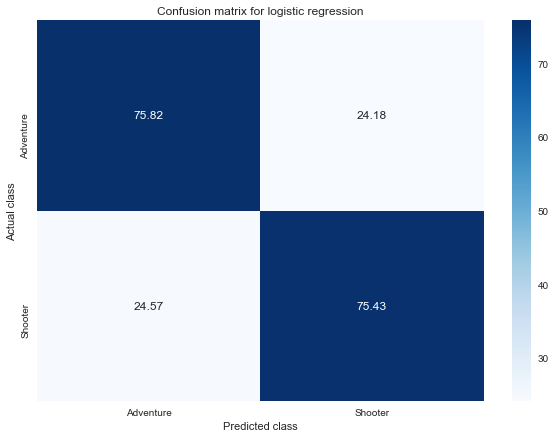

2 genres entailing 3662 MIDIs will be considered.
The genres are: Puzzle, Shooter
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Shooter,Puzzle
Repartition,0.603495,0.396505


Train    Test
accuracy mean  100.00%  73.70%
         std     0.00%   1.40%
f1-score mean  100.00%  59.68%
         std     0.00%   2.28%
ROC AUC  mean  100.00%  80.69%
         std     0.00%   1.71%

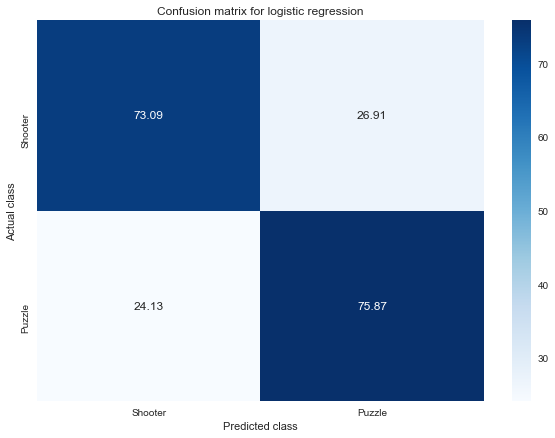

2 genres entailing 3000 MIDIs will be considered.
The genres are: Racing, Shooter
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Racing,Shooter
Repartition,0.262333,0.737667


Train    Test
accuracy mean  100.00%  77.20%
         std     0.00%   0.86%
f1-score mean  100.00%  86.43%
         std     0.00%   0.45%
ROC AUC  mean  100.00%  81.18%
         std     0.00%   2.30%

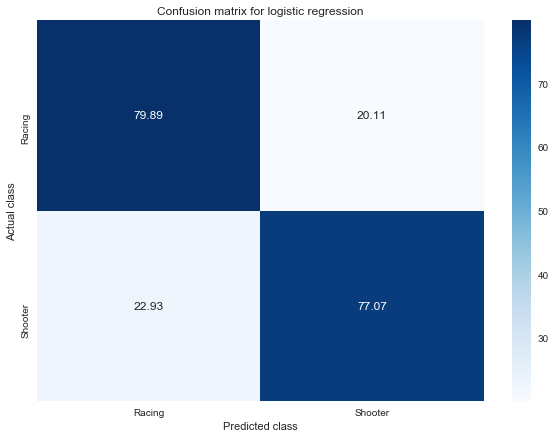

2 genres entailing 3354 MIDIs will be considered.
The genres are: Shooter, Sports
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Sports,Shooter
Repartition,0.333333,0.666667


Train    Test
accuracy mean  100.00%  73.23%
         std     0.00%   1.16%
f1-score mean  100.00%  82.78%
         std     0.00%   0.76%
ROC AUC  mean  100.00%  77.86%
         std     0.00%   1.81%

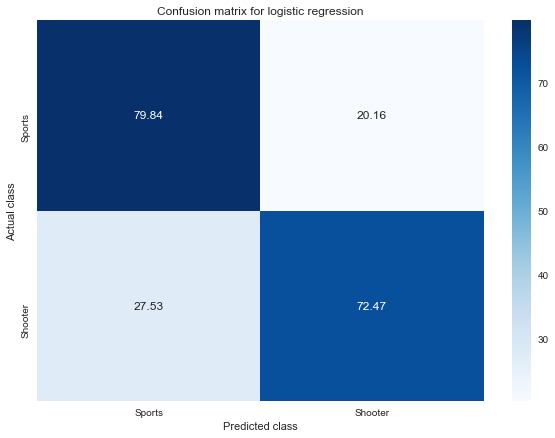

2 genres entailing 3330 MIDIs will be considered.
The genres are: Shooter, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Strategy,Shooter
Repartition,0.328228,0.671772


Train    Test
accuracy mean   99.98%  75.64%
         std     0.02%   1.27%
f1-score mean   99.98%  84.04%
         std     0.01%   0.76%
ROC AUC  mean  100.00%  80.52%
         std     0.00%   1.56%

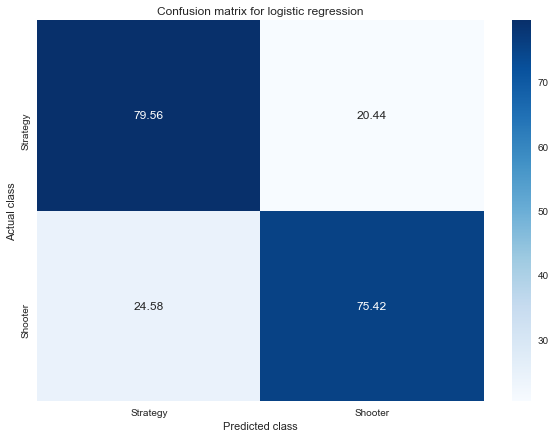

2 genres entailing 8386 MIDIs will be considered.
The genres are: Fighting, Role-Playing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Role-Playing,Fighting
Repartition,0.780229,0.219771


Train    Test
accuracy mean  100.00%  82.65%
         std     0.00%   0.60%
f1-score mean  100.00%  41.87%
         std     0.00%   1.56%
ROC AUC  mean  100.00%  85.50%
         std     0.00%   0.53%

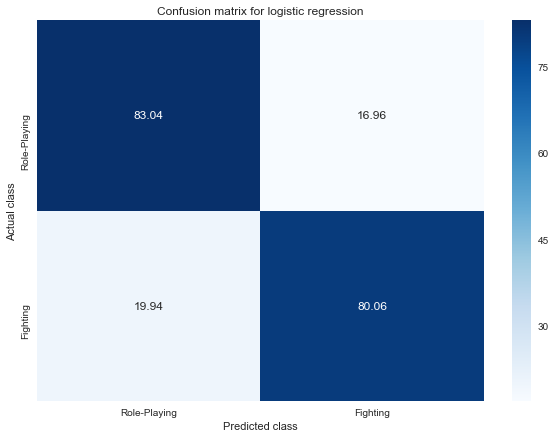

2 genres entailing 8345 MIDIs will be considered.
The genres are: Adventure, Role-Playing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Adventure,Role-Playing
Repartition,0.394967,0.605033


Train    Test
accuracy mean  100.00%  70.88%
         std     0.00%   1.72%
f1-score mean  100.00%  78.23%
         std     0.00%   1.50%
ROC AUC  mean  100.00%  77.28%
         std     0.00%   2.04%

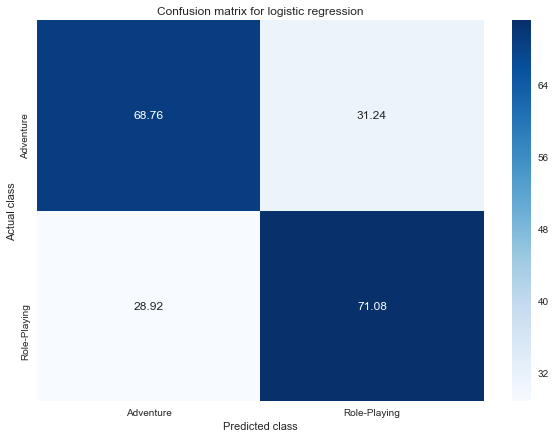

2 genres entailing 6985 MIDIs will be considered.
The genres are: Puzzle, Role-Playing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Role-Playing,Puzzle
Repartition,0.862563,0.137437


Train    Test
accuracy mean  100.00%  87.32%
         std     0.00%   0.20%
f1-score mean  100.00%  16.40%
         std     0.00%   1.97%
ROC AUC  mean  100.00%  81.09%
         std     0.00%   1.32%

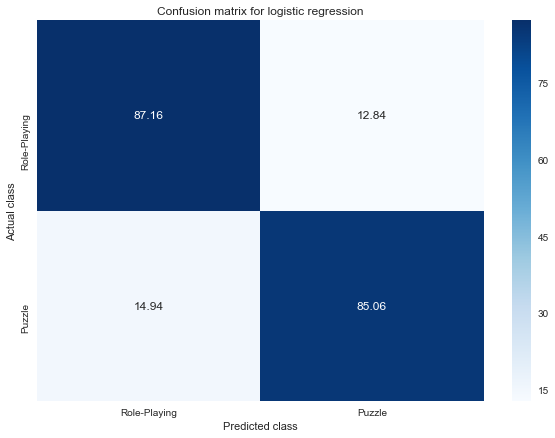

2 genres entailing 7359 MIDIs will be considered.
The genres are: Racing, Role-Playing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Role-Playing,Racing
Repartition,0.889523,0.110477


Train    Test
accuracy mean   99.99%  90.00%
         std     0.01%   0.17%
f1-score mean   99.94%  21.18%
         std     0.03%   2.07%
ROC AUC  mean  100.00%  90.12%
         std     0.00%   1.18%

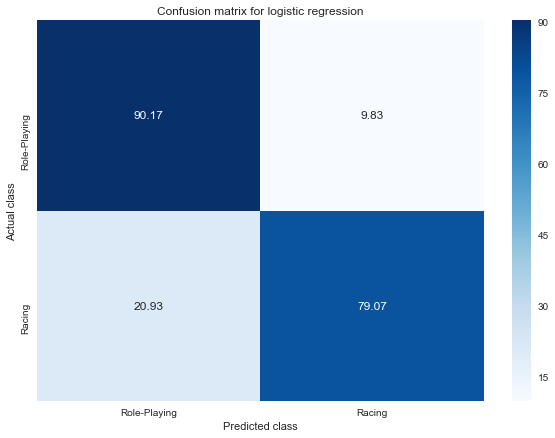

2 genres entailing 7597 MIDIs will be considered.
The genres are: Role-Playing, Sports
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Sports,Role-Playing
Repartition,0.142951,0.857049


Train    Test
accuracy mean  100.00%  86.40%
         std     0.00%   0.21%
f1-score mean  100.00%  92.64%
         std     0.00%   0.11%
ROC AUC  mean  100.00%  78.85%
         std     0.00%   0.66%

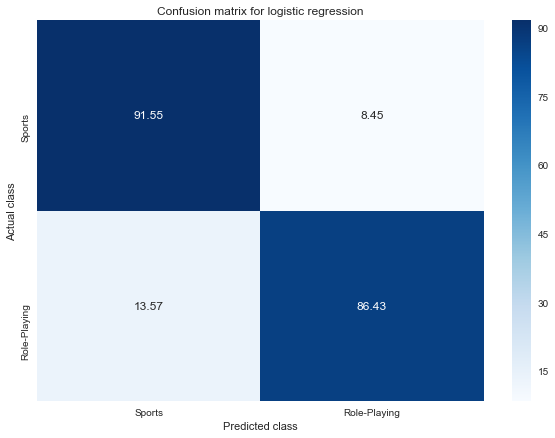

2 genres entailing 6735 MIDIs will be considered.
The genres are: Role-Playing, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Strategy,Role-Playing
Repartition,0.095323,0.904677


Train    Test
accuracy mean  100.00%  90.60%
         std     0.00%   0.10%
f1-score mean  100.00%  95.06%
         std     0.00%   0.05%
ROC AUC  mean  100.00%  77.42%
         std     0.00%   1.63%

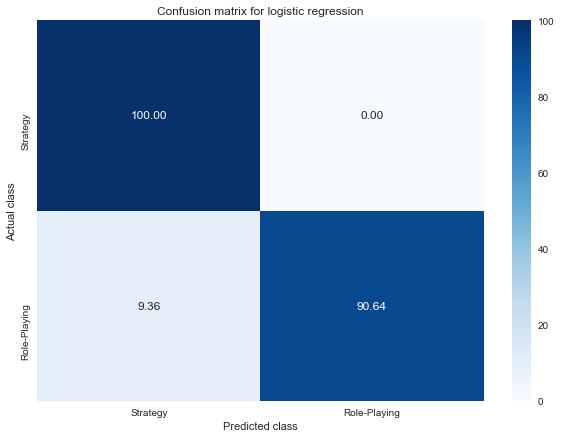

2 genres entailing 6547 MIDIs will be considered.
The genres are: Adventure, Fighting
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Adventure,Fighting
Repartition,0.725065,0.274935


Train    Test
accuracy mean   99.98%  79.24%
         std     0.01%   0.73%
f1-score mean   99.97%  46.30%
         std     0.03%   1.95%
ROC AUC  mean  100.00%  82.53%
         std     0.00%   0.43%

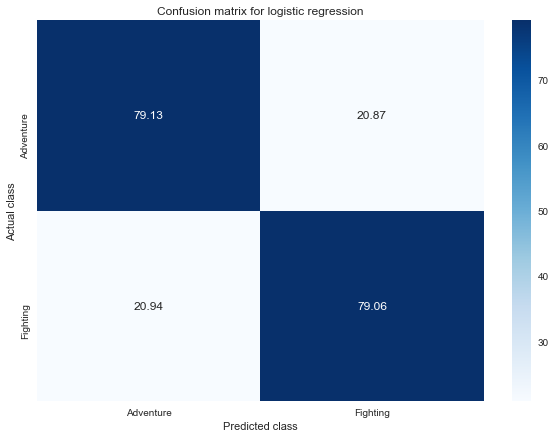

2 genres entailing 3327 MIDIs will be considered.
The genres are: Fighting, Puzzle
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Puzzle,Fighting
Repartition,0.445146,0.554854


Train    Test
accuracy mean   99.97%  76.53%
         std     0.02%   1.20%
f1-score mean   99.97%  79.90%
         std     0.01%   1.07%
ROC AUC  mean  100.00%  85.43%
         std     0.00%   0.46%

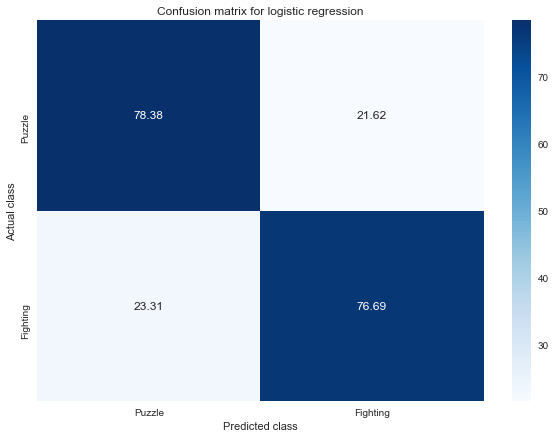

2 genres entailing 2659 MIDIs will be considered.
The genres are: Fighting, Racing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Racing,Fighting
Repartition,0.305754,0.694246


Train    Test
accuracy mean  100.00%  75.59%
         std     0.00%   1.24%
f1-score mean  100.00%  84.89%
         std     0.00%   0.68%
ROC AUC  mean  100.00%  79.79%
         std     0.00%   0.82%

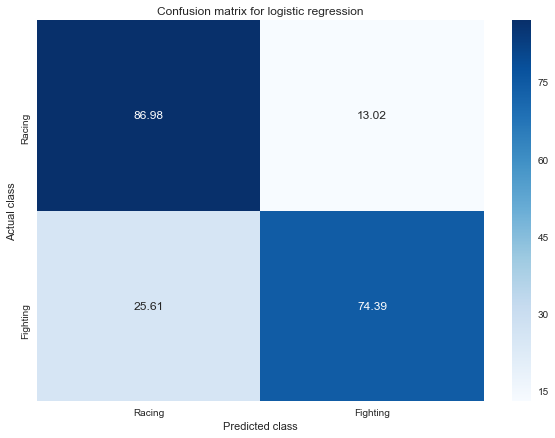

2 genres entailing 2543 MIDIs will be considered.
The genres are: Fighting, Sports
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Sports,Fighting
Repartition,0.357452,0.642548


Train    Test
accuracy mean   99.89%  75.66%
         std     0.06%   1.47%
f1-score mean   99.92%  83.28%
         std     0.04%   0.90%
ROC AUC  mean  100.00%  82.21%
         std     0.00%   1.01%

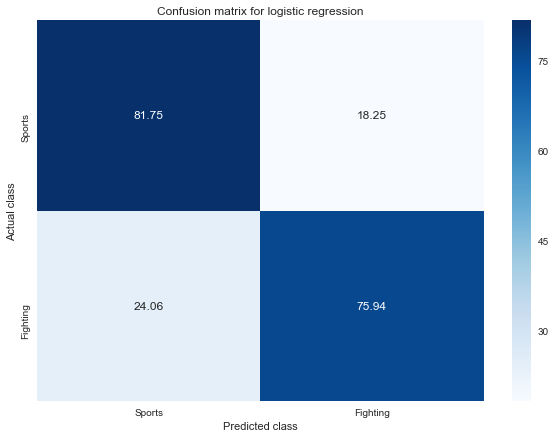

2 genres entailing 2939 MIDIs will be considered.
The genres are: Fighting, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Strategy,Fighting
Repartition,0.372235,0.627765


Train    Test
accuracy mean  100.00%  76.22%
         std     0.00%   1.40%
f1-score mean  100.00%  82.90%
         std     0.00%   0.87%
ROC AUC  mean  100.00%  83.23%
         std     0.00%   0.92%

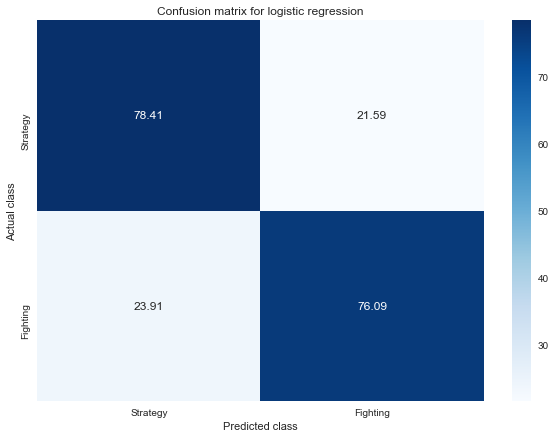

2 genres entailing 5076 MIDIs will be considered.
The genres are: Adventure, Puzzle
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Adventure,Puzzle
Repartition,0.826241,0.173759


Train    Test
accuracy mean  100.00%  83.43%
         std     0.01%   0.32%
f1-score mean   99.99%   9.44%
         std     0.03%   2.66%
ROC AUC  mean  100.00%  77.45%
         std     0.00%   1.35%

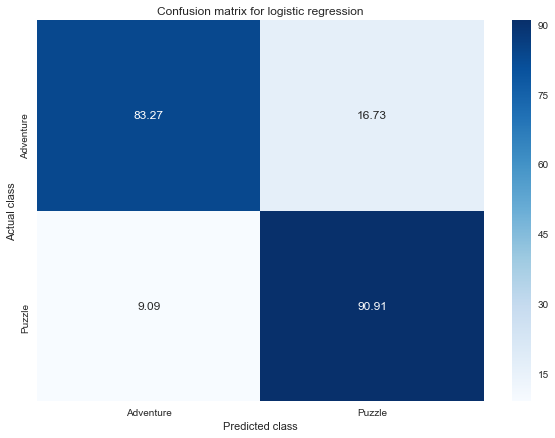

2 genres entailing 5494 MIDIs will be considered.
The genres are: Adventure, Racing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Adventure,Racing
Repartition,0.862213,0.137787


Train    Test
accuracy mean  100.00%  88.00%
         std     0.00%   0.44%
f1-score mean  100.00%  27.18%
         std     0.00%   2.69%
ROC AUC  mean  100.00%  86.07%
         std     0.00%   1.09%

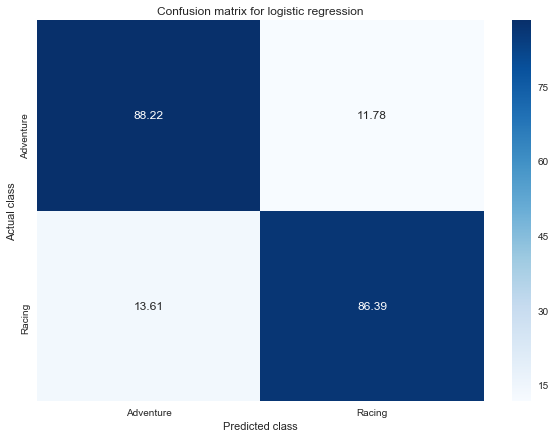

2 genres entailing 5766 MIDIs will be considered.
The genres are: Adventure, Sports
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Adventure,Sports
Repartition,0.818418,0.181582


Train    Test
accuracy mean   99.99%  82.90%
         std     0.01%   0.23%
f1-score mean   99.96%  11.80%
         std     0.03%   1.74%
ROC AUC  mean  100.00%  76.27%
         std     0.00%   1.65%

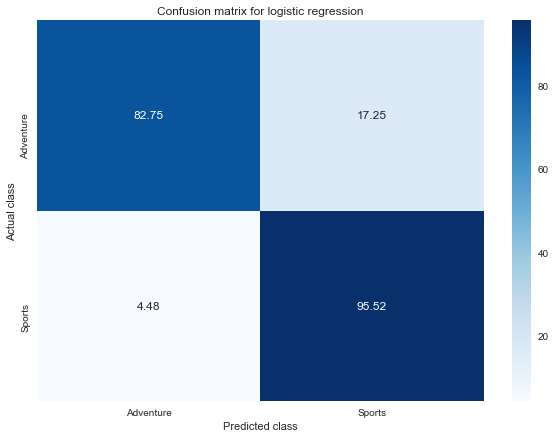

2 genres entailing 5670 MIDIs will be considered.
The genres are: Adventure, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Adventure,Strategy
Repartition,0.826102,0.173898


Train    Test
accuracy mean   99.98%  83.47%
         std     0.01%   0.30%
f1-score mean   99.95%   9.94%
         std     0.03%   3.07%
ROC AUC  mean  100.00%  75.14%
         std     0.00%   1.55%

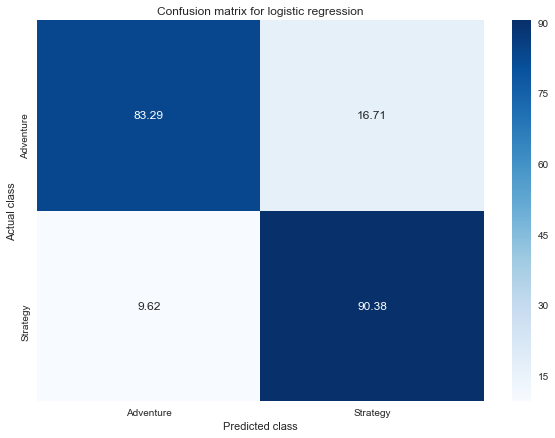

2 genres entailing 2256 MIDIs will be considered.
The genres are: Puzzle, Racing
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Racing,Puzzle
Repartition,0.35195,0.64805


Train    Test
accuracy mean  100.00%  80.10%
         std     0.00%   2.14%
f1-score mean  100.00%  85.73%
         std     0.00%   1.54%
ROC AUC  mean  100.00%  86.96%
         std     0.00%   1.25%

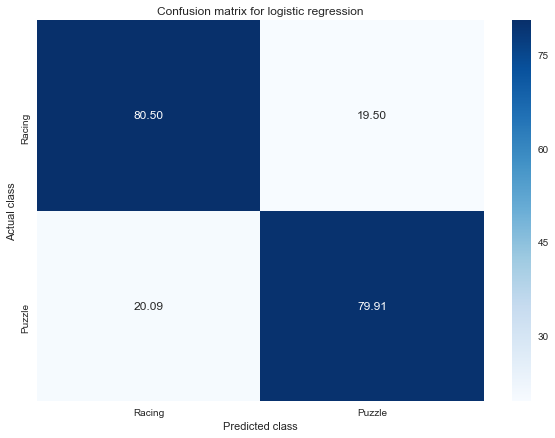

2 genres entailing 2594 MIDIs will be considered.
The genres are: Puzzle, Sports
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Sports,Puzzle
Repartition,0.430609,0.569391


Train    Test
accuracy mean  100.00%  70.39%
         std     0.00%   1.30%
f1-score mean  100.00%  76.36%
         std     0.00%   1.42%
ROC AUC  mean  100.00%  76.74%
         std     0.00%   0.71%

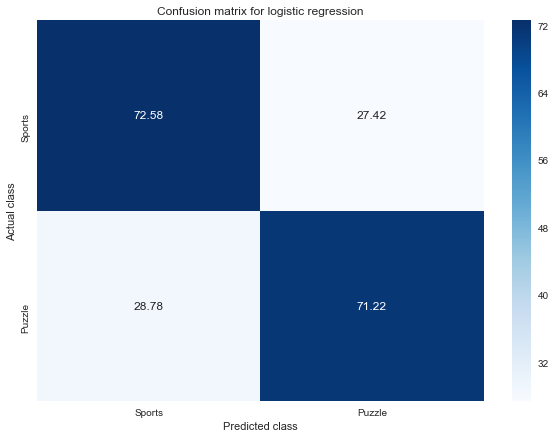

2 genres entailing 2510 MIDIs will be considered.
The genres are: Puzzle, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Strategy,Puzzle
Repartition,0.423108,0.576892


Train    Test
accuracy mean  100.00%  69.72%
         std     0.00%   1.60%
f1-score mean  100.00%  76.34%
         std     0.00%   1.17%
ROC AUC  mean  100.00%  75.85%
         std     0.00%   1.91%

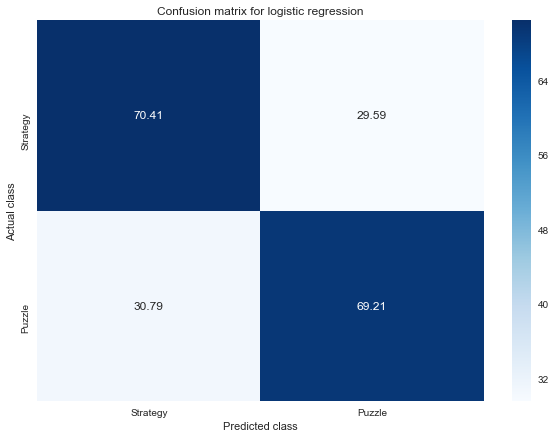

2 genres entailing 1890 MIDIs will be considered.
The genres are: Racing, Sports
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Sports,Racing
Repartition,0.581481,0.418519


Train    Test
accuracy mean  100.00%  73.97%
         std     0.00%   1.95%
f1-score mean  100.00%  63.03%
         std     0.00%   2.79%
ROC AUC  mean  100.00%  82.73%
         std     0.00%   2.49%

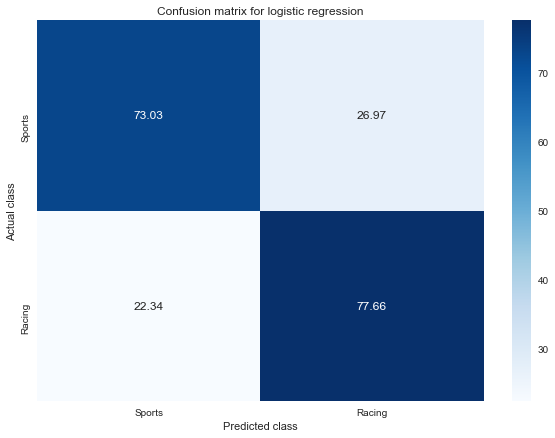

2 genres entailing 1898 MIDIs will be considered.
The genres are: Racing, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Strategy,Racing
Repartition,0.574289,0.425711


Train    Test
accuracy mean  100.00%  79.03%
         std     0.00%   1.83%
f1-score mean  100.00%  74.13%
         std     0.00%   2.15%
ROC AUC  mean  100.00%  87.19%
         std     0.00%   1.67%

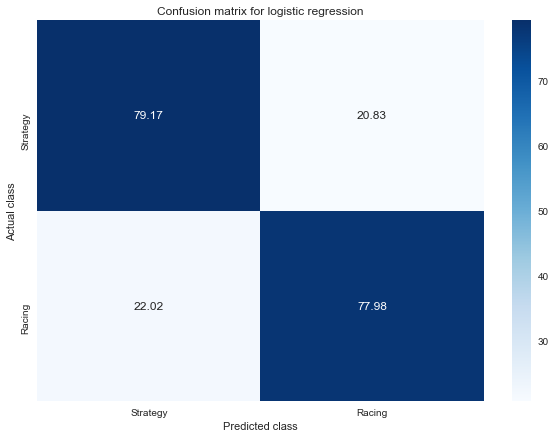

2 genres entailing 2056 MIDIs will be considered.
The genres are: Sports, Strategy
0.000% of the midis are duplicates
<class 'pandas.core.indexes.base.Index'>


,Strategy,Sports
Repartition,0.493677,0.506323


Train    Test
accuracy mean  100.00%  69.79%
         std     0.00%   1.38%
f1-score mean  100.00%  70.15%
         std     0.00%   1.46%
ROC AUC  mean  100.00%  77.89%
         std     0.00%   1.22%

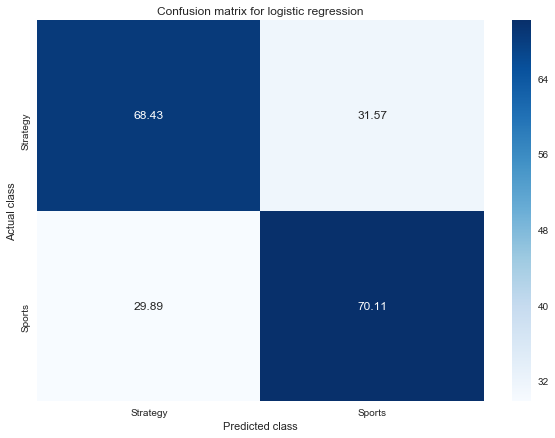

In [18]:
selected_genres = ['Action', 'Platform', 'Shooter', 'Role-Playing', 'Fighting', 'Adventure', 'Puzzle', 'Racing', 'Sports', 'Strategy']
all_features = []
all_scores = []
for genres in itertools.combinations(selected_genres, 2):
    features = test_with_filters(
        clf= RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1),
        genres_filter=df_genres['genre'].isin(genres),
        midis_treshold=0,
        drop_duplicates=True,
        repartition=True,
        conf_matrix=True);
    all_features.append(features) 
np.save("features2", all_features)


In [14]:
np.load("features1.npy")

array([[['Quintuple_Meter', 'Major_or_Minor',
         'Compound_Or_Simple_Meter', ..., 'Strong_Tonal_Centres',
         'Most_Common_Melodic_Interval', 'Number_of_Common_Pitches'],
        [8.732893228429271e-05, 0.00029943960090209363,
         0.00035874548790805987, ..., 0.002242166744319979,
         0.0022965398858415475, 0.0026376165130207966]],

       [['Quintuple_Meter', 'Major_or_Minor',
         'Compound_Or_Simple_Meter', ...,
         'Relative_Range_Isolation_of_Loudest_Voice',
         'Acoustic_Guitar_Prevalence', 'Number_of_Common_Pitches'],
        [8.04384526965828e-05, 0.00013048552307934802,
         0.0002612289180837148, ..., 0.002229586625897331,
         0.002349451973640347, 0.0023700877427001816]],

       [['Quintuple_Meter', 'Major_or_Minor',
         'Compound_Or_Simple_Meter', ..., 'Average_Range_of_Glissandos',
         'Number_of_Common_Pitches',
         'Number_of_Common_Melodic_Intervals'],
        [8.383202822757847e-05, 0.00020833488293220672,
   

In [19]:
np.load("features2.npy")

array([[['Note_Density', 'Rhythmic_Variability',
         'Average_Time_Between_Attacks', ...,
         'Average_Rest_Fraction_Per_Voice', 'Average_Note_Duration',
         'Variability_of_Note_Durations'],
        [0.009178310385900107, 0.009229351305906077,
         0.009312324352880909, ..., 0.010417016010017023,
         0.012009431434859871, 0.014445908329455241]],

       [['Melodic_Pitch_Variety',
         'Prevalence_of_Most_Common_Vertical_Interval',
         'Variability_of_Number_of_Simultaneous_Pitches', ...,
         'Vertical_Unisons', 'Repeated_Notes', 'Amount_of_Arpeggiation'],
        [0.009603503853317364, 0.009644772140777962,
         0.009718673829050112, ..., 0.012021846683427406,
         0.012738281013315825, 0.0131037160525704]],

       [['Importance_of_Bass_Register',
         'Combined_Strength_of_Two_Strongest_Rhythmic_Pulses',
         'Percussion_Instrument_Prevalence', ...,
         'Average_Note_Duration', 'Variability_of_Note_Durations',
         'Stri

In [15]:
np.load("features3.npy")

array([[['Variability_of_Time_Between_Attacks', 'Duration',
         'Prevalence_of_Most_Common_Pitch_Class', ...,
         'Maximum_Note_Duration', 'Average_Note_Duration',
         'Variability_of_Note_Durations'],
        [0.00904338245875981, 0.009172749685784853,
         0.009214986405067916, ..., 0.01116835727535613,
         0.012353588192482843, 0.014183906998520122]],

       [['Stepwise_Motion', 'Average_Number_of_Independent_Voices',
         'Average_Length_of_Melodic_Arcs', ...,
         'Amount_of_Arpeggiation', 'Vertical_Unisons',
         'Vertical_Sixths'],
        [0.009336499325419582, 0.009363161388180184,
         0.009385367186453494, ..., 0.011832913007656341,
         0.012166006623757395, 0.013536135809988786]],

       [['Importance_of_Bass_Register', 'Note_Density',
         'Percussion_Instrument_Prevalence', ...,
         'Variability_of_Note_Durations', 'Average_Note_Duration',
         'String_Ensemble_Prevalence'],
        [0.010377202088776759, 0.01077